<a href="https://colab.research.google.com/github/teias-courses/dl99/blob/gh-pages/resources/hands_on_with_tf_CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Work with data 

In [ ]:
#@title download data
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xvzf /content/cifar-10-python.tar.gz

In [ ]:
#@title import libs

import tensorflow as tf
import os
import numpy as np 
import pickle

In [ ]:
#@title load dataset from files

def unpickle(file):
  with open(file, 'rb') as fo:
    data = pickle.load(fo, encoding='bytes')
  return data

raw_data_parts = []
raw_labels_parts = []

for file_name in (os.listdir("/content/cifar-10-batches-py")):
  if ("data_batch" in file_name):
    part = unpickle(os.path.join("/content/cifar-10-batches-py",
                                 file_name))
    raw_data_parts.append(part[b'data'])
    raw_labels_parts.append(part[b'labels'])

raw_data = np.concatenate(raw_data_parts, axis=0)
raw_labels = np.concatenate(raw_labels_parts, axis=0)

In [ ]:
#@title define data processor funcs (YOUR PART #1)

def process_image(flat_images, labels):   # image is tensor of shape (3072), label is a scalar tensor
  #################
  # provess image #
  #################
  return (normalized_images, labels) # normalized tensor of shape (32, 32, 3), label unchanged
 
def process_labels(images, labels):
  one_hot_labels = tf.one_hot(labels, depth=10)
  return (images, one_hot_labels) 

In [ ]:
#@title data process, split using tf.data

AUTOTUNE = tf.data.experimental.AUTOTUNE 

tf_dataset = tf.data.Dataset.from_tensor_slices((raw_data, raw_labels))

tf_dataset = tf_dataset.map(process_image, num_parallel_calls=AUTOTUNE)
tf_dataset = tf_dataset.map(process_labels, num_parallel_calls=AUTOTUNE)
tf_dataset = tf_dataset.shuffle(1000)
tf_dataset = tf_dataset.batch(64)
tf_dataset = tf_dataset.prefetch(AUTOTUNE)

test_size = 50
val_size = 25
train_size = 250

tf_test_set = tf_dataset.take(test_size)
tf_val_set = tf_dataset.skip(test_size).take(val_size)
tf_train_set = tf_dataset.skip(test_size+val_size)

a_batch = next(iter(tf_val_set))
print('input batch shape:', a_batch[0].shape, '\nlabel batch shape', a_batch[1].shape)
print('\ninput tensor:', a_batch[0][0], '\nlabel tensor', a_batch[1][0])

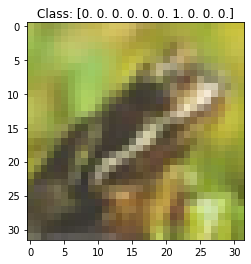

In [ ]:
#@title view a data example
a_batch = next(iter(tf_val_set))
i = 2 #@param {type:"integer"}
plt.title(f'Class: {a_batch[1][i].numpy()}')
plt.imshow(a_batch[0][i])
plt.show()

# 2. Design and train the model 


In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        51264     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        102464    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)          0   

In [ ]:
#@ title define, compile model using functional api (YOUR PART #2)

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam

input_image = Input((32,32, 3))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_image)

################
# define model #
################

model = Model(inputs=input_image, outputs=x)    # output?

learning_rate = 0.002 #@param {"type": "number"}
model.compile (optimizer=Adam(lr=learning_rate), 
               loss='categorical_crossentropy',
               metrics=['accuracy'])

In [ ]:
#@title train model
epochs = 10 #@param {type:"integer"}

history = model.fit(tf_train_set,
                    validation_data=tf_val_set,
                    epochs=epochs)

In [ ]:
#@title plot learning curve
from matplotlib import pyplot as plt

plt.title('Loss')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val loss')

plt.legend()
plt.show()

plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')

plt.legend()
plt.show()

In [ ]:
#@title evaluate model on test set
model.evaluate(tf_test_set)